In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/sueki_data/20220222_sueki_dataset.zip

# パッケージインストール


In [ ]:
!pip install -q japanize_matplotlib
!pip install -q tensorflow-determinism classification-models-3D

     |████████████████████████████████| 4.1 MB 9.8 MB/s 
     |████████████████████████████████| 46 kB 3.3 MB/s 


# 仮ラベル付きのクラスタリング

In [ ]:
import os
from glob import glob
import re
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
import gc

from skimage.transform import resize
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from matplotlib import cm
from keras.utils import np_utils

In [ ]:

def set_seed(seed=200):
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    

set_seed(123)


## 定数定義

In [ ]:
NUM_CLASSES = 8
NUM_CLUSTERS = 8
NUM_PCA_COMPONENTS = 8
BUFFER_SIZE = 1000
BATCH_SIZE = 16 
EPOCHS = 50
CLUSTERING_INTERVAL = 1
DATA_DIR = '/content/data/voxel'
MI_FUTA = 'mi'
IMAGE_SIZE = 64
NUM_CHANNELS = 4

FEATURE_EXTRACTOR_MODEL_PATH = "feature_extractor_20220222-selu-i_{}_cls{}_ep{}.hdf5".format(MI_FUTA,NUM_CLUSTERS,EPOCHS)
CLASSIFIER_MODEL_PATH = "classifier_20220222-selu-i_{}_cls{}_ep{}.hdf5".format(MI_FUTA,NUM_CLUSTERS,EPOCHS)
DATASET_SAVE_PATH = "pseudo_dataset_20220222-selu-i_{}_cls{}_ep{}".format(MI_FUTA,NUM_CLUSTERS,EPOCHS)

DATASAVE_DIR = "{}_20220222-selu-i_deg30_cls{}_ep{}".format(MI_FUTA,NUM_CLUSTERS,EPOCHS)


## モデル定義

In [ ]:
class ConvNet3D(keras.Model):
    def __init__(self):
        super(ConvNet3D, self).__init__()
        self.conv3d_1 = keras.layers.Conv3D(filters=64, kernel_initializer='lecun_normal', kernel_size=3, activation='linear', name='conv3d_1')
        self.bn_1 = keras.layers.BatchNormalization()
        self.act_1 = keras.layers.Activation('selu')
        self.maxpool3d_1 = keras.layers.MaxPool3D(pool_size=2)
        
        
        self.conv3d_2 = keras.layers.Conv3D(filters=64, kernel_initializer='lecun_normal', kernel_size=3, activation='linear', name='conv3d_2')
        self.bn_2 = keras.layers.BatchNormalization()
        self.act_2 = keras.layers.Activation('selu')
        self.maxpool3d_2 = keras.layers.MaxPool3D(pool_size=2)
        
        
        self.conv3d_3 = keras.layers.Conv3D(filters=128, kernel_initializer='lecun_normal', kernel_size=3, activation='linear', name='conv3d_3')
        self.bn_3 = keras.layers.BatchNormalization()
        self.act_3 = keras.layers.Activation('selu')
        self.maxpool3d_3 = keras.layers.MaxPool3D(pool_size=2)
        
        
        self.conv3d_4 = keras.layers.Conv3D(filters=256, kernel_initializer='lecun_normal', kernel_size=3, activation='linear', name='conv3d_4')
        self.bn_4 = keras.layers.BatchNormalization()
        self.act_4 = keras.layers.Activation('selu')
        self.maxpool3d_4 = keras.layers.MaxPool3D(pool_size=1)
        

        self.gap_1 = keras.layers.GlobalAveragePooling3D()
        
        self.dense_1 = keras.layers.Dense(128, kernel_initializer='lecun_normal')
        self.dense_2 = keras.layers.Dense(128, kernel_initializer='lecun_normal')

    def call(self, inputs):
        x = self.conv3d_1(inputs)
        x = self.bn_1(x)
        x = self.act_1(x)
        x = self.maxpool3d_1(x)
        
        x = self.conv3d_2(x)
        x = self.bn_2(x)
        x = self.act_2(x)
        x = self.maxpool3d_2(x)
        
        x = self.conv3d_3(x)
        x = self.bn_3(x)
        x = self.act_3(x)
        x = self.maxpool3d_3(x)
        
        x = self.conv3d_4(x)
        x = self.bn_4(x)
        x = self.act_4(x)
        x = self.maxpool3d_4(x)
        
        x = self.gap_1(x)
        x_1 = self.dense_1(x)
        x_2 = self.dense_2(x)
        return [x_1, x_2]

In [ ]:
class Classify3D(tf.keras.Model):
    def __init__(self, feature_extractor, num_of_classes=3):
        super(Classify3D, self).__init__()
        self.feature_extractor = feature_extractor
        self.num_of_classes = num_of_classes
        self.activation_1 = keras.layers.Activation(keras.activations.selu)
        self.activation_2 = keras.layers.Activation(keras.activations.selu)
        self.dense_1 = keras.layers.Dense(self.num_of_classes, activation='softmax')
        self.dense_2 = keras.layers.Dense(self.num_of_classes, activation='softmax')
        
    def call(self, inputs):
        x_1, x_2 = self.feature_extractor(inputs)
        x_1 = self.activation_1(x_1)
        x_1 = self.dense_1(x_1)
        x_2 = self.activation_2(x_2)
        x_2 = self.dense_2(x_2)

        return [x_1, x_2]

In [ ]:
feature_extractor = ConvNet3D()
feature_extractor.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
feature_extractor.summary()

Model: "conv_net3d_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_1 (Conv3D)           multiple                  6976      
                                                                 
 batch_normalization_3 (Batc  multiple                 256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   multiple                  0         
                                                                 
 max_pooling3d_4 (MaxPooling  multiple                 0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           multiple                  110656    
                                                                 
 batch_normalization_4 (Batc  multiple                

In [ ]:
classifier = Classify3D(feature_extractor, num_of_classes=NUM_CLASSES)
classifier.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
classifier.summary()

Model: "classify3d_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_net3d_1 (ConvNet3D)    multiple                  1291776   
                                                                 
 activation_10 (Activation)  multiple                  0         
                                                                 
 activation_11 (Activation)  multiple                  0         
                                                                 
 dense_6 (Dense)             multiple                  1032      
                                                                 
 dense_7 (Dense)             multiple                  1032      
                                                                 
Total params: 1,293,840
Trainable params: 1,292,816
Non-trainable params: 1,024
_________________________________________________________________


In [ ]:
pca = PCA(n_components=NUM_PCA_COMPONENTS)

stdsc = StandardScaler()

kmc = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', n_init=2, max_iter=300,
                       tol=0.0001, verbose=0, random_state=123, copy_x=True)

## データ準備

In [ ]:
categories1 = ['2-1','2-2','2-3','2-4','2-5','temp1-1','temp1-2','temp1-3']#,'temp1-4','temp1-5']
categories2 = ['前葉','中葉','後葉', 'temp2-1','temp2-2','temp2-3','temp2-4','temp2-5']#,'temp2-6','temp2-7']

In [ ]:
label_dict = {
  'J-3651':['2-3','中葉'],#蓋  ##追加20220217
  'J-13305-5':['2-3','中葉'],#蓋
  'J-6568':['2-3','中葉'],#蓋
  'J-22896-1':['2-4','後葉'],#蓋
  'J-22896-2':['2-4','後葉'],#蓋
  'J-22896-4':['2-4','後葉'],#蓋
  'J-3457':['2-5','後葉'],#蓋
  'J-6569':['2-5','後葉'],#蓋
  'J-14876':['2-5','後葉'],#蓋  ##追加20220222
  'J-20215':['2-5','後葉'],#蓋
  'J-22896-3':['2-5','後葉'],#蓋
  'J-22896-9':['2-5','後葉'],#蓋  ##追加20220217
  'J-23682':['2-5','後葉'],#蓋  ##追加20220222

  'J-6564':['2-3','中葉'],#蓋と身
  'J-6574':['2-3','中葉'],#蓋と身
  'J-13305-2':['2-3','中葉'],#蓋と身
  'J-23050':['2-4','後葉'],#蓋と身  ##20220210追加
  'J-11536':['2-5','後葉'],#蓋と身  ##追加20220222


  'J-142':['2-3','中葉'],#身 ##追加20220214
  'J-3516':['2-3','中葉'],#身  ##追加20220214
  'J-3527':['2-3','中葉'],#身  ##追加20220214
  'J-3583':['2-3','中葉'],#身
  'J-5834':['2-3','中葉'],#身  ##追加20220217
  'J-6565':['2-3','中葉'],#身
  'J-3603':['2-4','後葉'],#身 ##20220208追加
  'J-6571':['2-4','後葉'],#身

  'J-8828-3':['2-4','後葉'],#身
  'J-8828-5':['2-4','後葉'],#身
  'J-22896-15':['2-4','後葉'],#身  ##追加20220217
  'J-3650':['2-5','後葉'],#身  ##追加20220222
  'J-9830':['2-5','後葉'],#身
  'J-22266':['2-5','後葉'],#身
  'J-22896-12':['2-5','後葉'],#身  ##追加20220217
  'J-22896-16':['2-5','後葉'],#身  ##追加20220217
  'J-22896-19':['2-5','後葉'],#身  ##追加20220222
  'J-22896-21':['2-5','後葉'],#身  ##追加20220222
  
  'J-139':['2-1','前葉'],#蓋と身  ##追加20220217
  'J-11563':['2-1','前葉'],#蓋と身  ##追加20220217
  
  'J-7598':['2-1','前葉'],#蓋と身  ##20220210追加
  'J-3961':['2-1','前葉'],#身  ##追加20220214
  'J-20761':['2-1','前葉'],#身  ##追加20220214


  'J-147':['2-2','前葉'],#蓋 ##追加20220214
  'J-3522':['2-2','前葉'],#蓋

  'J-3920':['2-2','前葉'],#身  ##追加20220214
  'J-7606':['2-2','前葉'],#身  ##追加20220214
  'J-22802':['2-2','前葉'],#身


  'J-6572':['2-3','中葉'],#蓋
  'J-13305-3':['2-3','中葉'],#蓋
  'J-13305-6':['2-3','中葉'],#蓋
  'J-6570':['2-4','後葉'],#蓋
  'J-23049':['2-4','後葉'],#蓋  ##20220210追加
  'J-22896-8':['2-4','後葉'], #蓋

  'J-3667':['2-5','後葉'],#蓋
  'J-22896-7':['2-5','後葉'],#蓋
  'J-22896-10':['2-5','後葉'],#蓋  ##追加20220217

  
  'J-6573':['2-3','中葉'],#蓋と身
  'J-13305-1':['2-5','後葉'],#蓋と身
  'J-6566':['2-3','中葉'],#身
  'J-3648':['2-4','後葉'],#身
  'J-8828-6':['2-4','後葉'],#身
  'J-33902':['2-4','後葉'],#身 ##20220208追加
  'J-3619':['2-5','後葉'],#身 ##20220208追加
  'J-8828-8':['2-5','後葉'],#身
  'J-22896-13':['2-5','後葉'],#身  ##追加20220217
  'J-22896-22':['2-5','後葉'],#身  ##追加20220222


  'J-20295':['2-1','前葉'],#蓋  ##追加20220217
  'J-4120':['2-1','前葉'],#蓋と身 ##追加20220214


  'J-3589':['2-2','前葉'],#蓋  ##追加20220214
  'J-3634':['2-2','前葉'],#蓋と身  ##20220208追加  
  'J-3959':['2-2','前葉'],#身  ##追加20220214
  

  'J-3584':['2-3','中葉'],#蓋
  'J-13305-4':['2-3','中葉'],#蓋
  'J-22896-5':['2-4','後葉'],#蓋
  'J-22262':['2-5','後葉'],#蓋
  'J-22896-6':['2-5','後葉'],#蓋
  'J-22896-11':['2-5','後葉'],#蓋  ##追加20220217

  'J-134':['2-3','中葉'],#蓋と身 ##20220210追加（身が20220222で追加）
  'J-6575':['2-3','中葉'],#蓋と身

  'J-4121':['2-3','中葉'],#身 ##追加20220214
  'J-6576':['2-3','中葉'],#身
  'J-8828-7':['2-3','中葉'],#身
  'J-3453':['2-4','後葉'],#身
  'J-7337':['2-4','後葉'],#身
  'J-8828-4':['2-4','後葉'],#身
  'J-22896-17':['2-4','後葉'],#身  ##追加20220222
  'J-3510':['2-5','後葉'],#身  ##追加20220222
  'J-33900':['2-5','後葉'],#身
  'J-22896-14':['2-5','後葉'],#身  ##追加20220217

  'J-20297':['2-1','前葉'],#蓋  ##追加20220217
  'J-22806':['2-1','前葉'],#身

  'J-4081':['2-2','前葉'],#蓋  ##追加20220214
  'J-7607':['2-2','前葉'],#蓋と身  ##20220210追加
  'J-3682':['2-2','前葉'],#身  ##追加20220214

}


In [ ]:
train_pattern = DATA_DIR +'/{}_*_64_*.npy'.format(MI_FUTA)
#train_pattern = DATA_DIR +'/*_64_*.npy'
train_list_ds = tf.data.Dataset.list_files(train_pattern, shuffle=False)
cat_re = re.compile(r'.+/.+_(.+?)_[0-9]_[0-9]_[0-9]+_[0-9]+\.npy')
train_labels = [label_dict[cat_re.match(item.numpy().decode())[1]] for item in train_list_ds]
train_ids = [[categories1.index(cat[0]),categories2.index(cat[1])] for cat in train_labels]
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_ids, tf.int64))

In [ ]:
def read_npy_file(path):
    data = np.load(path.numpy())
    return tf.convert_to_tensor(data, dtype=tf.float32)

In [ ]:
train_3d_ds = train_list_ds.map(
        lambda item: tf.py_function(read_npy_file, [item], tf.float32)).cache(filename='./cache.tf-data')

## モデルの学習

In [ ]:
gc.collect()

1610

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1.0e-4)

#分類1(型式)
train_loss1 = tf.keras.metrics.Mean(name='train_loss1')
train_accuracy1 = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy1')

#分類2(年代)
train_loss2 = tf.keras.metrics.Mean(name='train_loss2')
train_accuracy2 = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy2')

for epoch in range(EPOCHS):
    if epoch % CLUSTERING_INTERVAL == 0:
        features_list= [feature_extractor(batch_x, training=False) \
                         for batch_x in train_3d_ds.batch(BATCH_SIZE)]
        

        #分類1（型式）のクラスタリング
        features1 = np.vstack([rslt[0] for rslt in features_list])
        #PCA
        features_pca1 = pca.fit_transform(features1)
        #PCA後標準化
        features_std1 = stdsc.fit_transform(features_pca1)
        km_predictions1 = kmc.fit_predict(features_std1) 
        cluster_matrix1 = np.zeros((NUM_CLASSES, NUM_CLUSTERS), dtype=np.int32)
   
        for i, cat_id in enumerate(train_label_ds.batch(BATCH_SIZE)):
            for true_1, kmp_1 in zip(cat_id[:,0],km_predictions1[i*BATCH_SIZE:(i+1)*BATCH_SIZE]):
              cluster_matrix1[true_1,kmp_1] += 1
        print("Epoch: {}, Distortion: {:.2f}".format(epoch, kmc.inertia_))
        print(cluster_matrix1)

        #分類2（年代）のクラスタリング
        features2 = np.vstack([rslt[1] for rslt in features_list])
        #PCA
        features_pca2 = pca.fit_transform(features2)
        #PCA後標準化
        features_std2 = stdsc.fit_transform(features_pca2)
        km_predictions2 = kmc.fit_predict(features_std2)
        cluster_matrix2 = np.zeros((NUM_CLASSES, NUM_CLUSTERS), dtype=np.int32)

        for i, cat_id in enumerate(train_label_ds.batch(BATCH_SIZE)):
          for true_2, kmp_2 in zip(cat_id[:,1],km_predictions2[i*BATCH_SIZE:(i+1)*BATCH_SIZE]):
            cluster_matrix2[true_2,kmp_2] += 1

        print("Epoch: {}, Distortion: {:.2f}".format(epoch, kmc.inertia_))
        print(cluster_matrix2)

        #仮ラベルのデータセット
        pseudo_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(\
                                                  np.array([km_predictions1,km_predictions2]).T, tf.int64))
        #仮ラベルの学習データセット
        train_dataset = tf.data.Dataset.zip((train_3d_ds, pseudo_label_ds)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:

            y = classifier(x_batch_train, training=True)

            loss1 = loss_fn(y_batch_train[:,0], y[0])
            loss2 = loss_fn(y_batch_train[:,1], y[1])

        grads = tape.gradient([loss1,loss2], classifier.trainable_weights)
        optimizer.apply_gradients(zip(grads, classifier.trainable_weights))

        #分類1（型式）のlossとacc計算
        train_loss1(loss1)
        train_accuracy1(y_batch_train[:,0], y[0])

        #分類2（年代）のlossとacc計算
        train_loss2(loss2) 
        train_accuracy2(y_batch_train[:,1], y[1])

    template = 'Epoch {}, Loss: {}, Accuracy: {}'
    #分類1（型式）の経過出力
    print (template.format(epoch+1,
                         train_loss1.result(),
                         train_accuracy1.result()*100))
    #reset0
    train_loss1.reset_states()
    train_accuracy1.reset_states()

    #分類2（年代）の経過出力
    print (template.format(epoch+1,
                         train_loss2.result(),
                         train_accuracy2.result()*100))
    
    #reset
    train_loss2.reset_states()
    train_accuracy2.reset_states()



Epoch: 0, Distortion: 2792.44
[[12  0  0 48  0  0 24  0]
 [ 0  0  0 50  0  0 34  0]
 [53 76  0 45  0  0  6 12]
 [46 12 28  0  0 12 22 36]
 [ 0 10 61  0 76 21  0 24]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
Epoch: 0, Distortion: 2858.13
[[12  0  0 59 13  0 84  0]
 [24 95  0  0 36  0 25 12]
 [68 15 92  0 39 79  0 55]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
Epoch 1, Loss: 0.7237655520439148, Accuracy: 83.33332824707031
Epoch 1, Loss: 0.7809150815010071, Accuracy: 79.80226135253906
Epoch: 1, Distortion: 2125.20
[[ 12  24   0   0   0  48   0   0]
 [  0  36   0   0   0  48   0   0]
 [ 24   0  12   0   0  48   0 108]
 [ 43  24  29   0  24   0  12  24]
 [  0   0  24  72  60   0  24  12]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]
Epoch: 1, Distortion: 2229.42
[[12  0  0 60 12 84  0  0]
 [36 96  0  

## 仮ラベル付きのデータセットとモデルを保存する
 ・Grad-CAMで仮ラベルを入力するため，データのパスと仮ラベルの組合せのデータセットを保存

In [ ]:
tf.data.experimental.save(tf.data.Dataset.zip((train_list_ds, pseudo_label_ds)), DATASET_SAVE_PATH)

In [ ]:
#load用
pseudo_dataset = tf.data.experimental.load(DATASET_SAVE_PATH)

In [ ]:
feature_extractor.save_weights(FEATURE_EXTRACTOR_MODEL_PATH)
classifier.save_weights(CLASSIFIER_MODEL_PATH)

In [ ]:
##ドライブへ一時退避
!mkdir /content/drive/MyDrive/sueki_data/{DATASAVE_DIR}
!cp -r {FEATURE_EXTRACTOR_MODEL_PATH} {CLASSIFIER_MODEL_PATH} {DATASET_SAVE_PATH} /content/drive/MyDrive/sueki_data/{DATASAVE_DIR}

## 学習済みモデルを使用したクラスタリング

In [ ]:
features_list = [feature_extractor(batch, training=False) for batch in train_3d_ds.batch(BATCH_SIZE)]

#分類1（型式）
features1 = np.vstack([rslt[0] for rslt in features_list])
#分類2（年代）
features2 = np.vstack([rslt[1] for rslt in features_list])


##PCA
features_pca1 = pca.fit_transform(features1)
features_pca2 = pca.fit_transform(features2)

#pca後標準化
features_std1 = stdsc.fit_transform(features_pca1)
features_std2 = stdsc.fit_transform(features_pca2)

#k-means
km_predictions1 = kmc.fit_predict(features_std1)
km_predictions2 = kmc.fit_predict(features_std2)


np.save('features1.npy', features1)
np.save('features2.npy', features2)
np.save('features_pca1.npy', features_pca1)
np.save('features_std1.npy', features_std1)
np.save('km_predictions1.npy', km_predictions1)
np.save('features_pca2.npy', features_pca2)
np.save('features_std2.npy', features_std2)
np.save('km_predictions2.npy', km_predictions2)

In [ ]:
num = []
futami = []
name = []
true_type = []
true_age = []
pseudo_type = []
pseudo_age = []
cluster_type = []
cluster_age = []


for i, d in enumerate(pseudo_dataset):
  futami.append(os.path.splitext(os.path.basename(d[0].numpy().decode()))[0].split('_',4)[0])
  name.append(os.path.splitext(os.path.basename(d[0].numpy().decode()))[0].split('_',4)[1])
  true_type.append(categories1[int(os.path.splitext(os.path.basename(d[0].numpy().decode()))[0].split('_',4)[2])])
  true_age.append(categories2[int(os.path.splitext(os.path.basename(d[0].numpy().decode()))[0].split('_',4)[3])])
  pseudo_type.append(d[1].numpy()[0])
  pseudo_age.append(d[1].numpy()[1])
  num.append(os.path.splitext(os.path.basename(d[0].numpy().decode()))[0].split('_',6)[5])

for k1, k2 in zip(km_predictions1,km_predictions2):
  cluster_type.append(k1)
  cluster_age.append(k2)
  
pseudo_df = pd.DataFrame(list(zip(futami, name, num, true_type, true_age, pseudo_type, pseudo_age, cluster_type, cluster_age)), columns = \
                  ['蓋・身','列品番号','回転角度','正解ラベル-型式','正解ラベル-時代','疑似ラベル-型式','疑似ラベル-時代','クラスタ-型式','クラスタ-時代'])
pseudo_df.to_csv(DATASET_SAVE_PATH+".csv")



In [ ]:
gc.collect()

50

## クラスラベルとクラスタの対応マッピング

In [ ]:
cluster_matrix1 = np.zeros((NUM_CLASSES, NUM_CLUSTERS), dtype=np.int32)

for i, cat_id in enumerate(train_label_ds.batch(BATCH_SIZE)):
    for true_1, kmp_1 in zip(cat_id[:,0],km_predictions1[i*BATCH_SIZE:(i+1)*BATCH_SIZE]):
      cluster_matrix1[true_1,kmp_1] += 1

In [ ]:
cluster_matrix2 = np.zeros((NUM_CLASSES, NUM_CLUSTERS), dtype=np.int32)

for i, cat_id in enumerate(train_label_ds.batch(BATCH_SIZE)):
    for true_2, kmp_2 in zip(cat_id[:,1],km_predictions2[i*BATCH_SIZE:(i+1)*BATCH_SIZE]):
      cluster_matrix2[true_2,kmp_2] += 1

In [ ]:
def plot_matrix(cm, x_labels, y_labels):
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=x_labels,
        yticklabels=y_labels,
        title='Cluster Matrix',
        ylabel='Class label',
        xlabel='Cluster id',
        xlim=(-0.5,cm.shape[1]-0.5),
        ylim=(cm.shape[0]-0.5,-0.5)
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor"
    )
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return fig

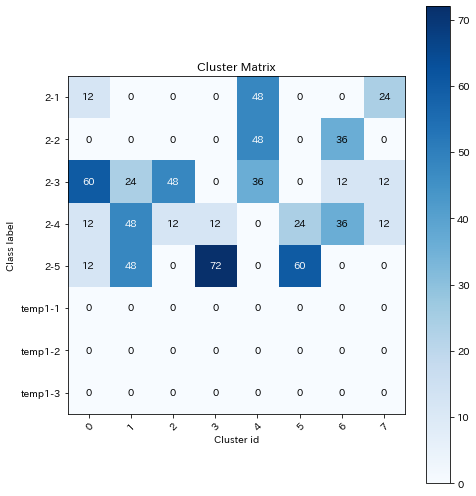

In [ ]:
fig = plot_matrix(cluster_matrix1, range(NUM_CLUSTERS), categories1)

In [ ]:
fig.savefig('cluster_matrix1.png')

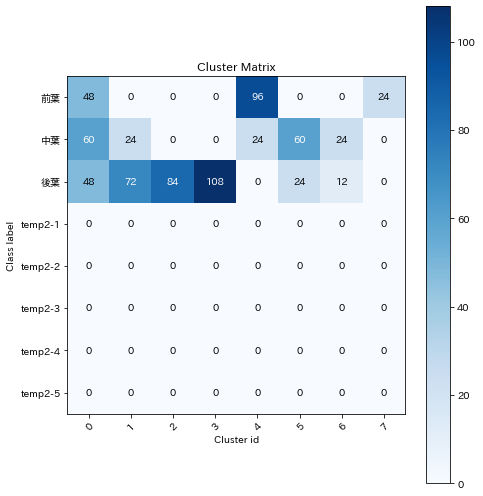

In [ ]:
fig = plot_matrix(cluster_matrix2, range(NUM_CLUSTERS), categories2)

In [ ]:
fig.savefig('cluster_matrix2.png')

## クラスタ可視化

### plot用のラベル

In [ ]:
#cc_re = re.compile(r'.+/(.+?)_[0-9]+_[0-9]+\.npy')
cc_re = re.compile(r'.+/.+_(.+?)_[0-9]_[0-9]_[0-9]+_[0-9]+\.npy')
aaa = [ cc_re.match(item.numpy().decode())[1] for item in train_list_ds]

### PCAを標準化

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
projections1 = tsne.fit_transform(features_std1)
fig = px.scatter(
    projections1, x=0, y=1,
    color=np.array(train_labels)[:,0],
    symbol=np.array(train_ids)[:,0],
    labels={'color': 'Categories'},
    title='PCA後標準化1',
    text=aaa,
    width=1000, height=1000,
)
fig.show()
fig.write_html("pca_std_1.html")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
tsne = TSNE(n_components=2, random_state=0)
projections2 = tsne.fit_transform(features_std2)
fig = px.scatter(
    projections2, x=0, y=1,
    color=np.array(train_labels)[:,1],
    symbol=np.array(train_ids)[:,1],
    labels={'color': 'Categories'},
    title='PCA後標準化2',
    text=aaa,
    width=1000, height=1000,
)
fig.show()
fig.write_html("pca_std_2.html")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



### エルボー法の適用

In [ ]:
inertias1 = []
for k in range(2,16):
    kmc = KMeans(n_clusters=k, init='k-means++', n_init=16, max_iter=300,
                           tol=0.0001, verbose=0, random_state=None, copy_x=True)

    km_predictions1 = kmc.fit_predict(features_std1)
    inertias1.append(kmc.inertia_)

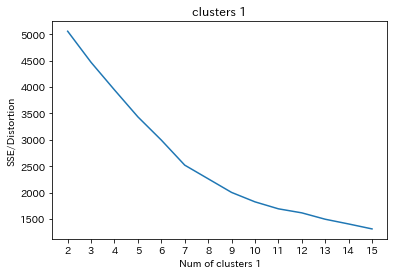

In [ ]:
plt.plot(range(2,16), inertias1, '-')
plt.xticks(range(2,16))
plt.title("clusters 1")
plt.xlabel('Num of clusters 1')
plt.ylabel('SSE/Distortion')
plt.savefig('elbow_chart_1.png')

In [ ]:
inertias2 = []
for k in range(2,16):
    kmc = KMeans(n_clusters=k, init='k-means++', n_init=16, max_iter=300,
                           tol=0.0001, verbose=0, random_state=None, copy_x=True)

    km_predictions2 = kmc.fit_predict(features_std2)
    inertias2.append(kmc.inertia_)

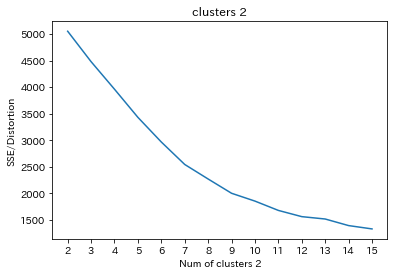

In [ ]:
plt.plot(range(2,16), inertias2, '-')
plt.xticks(range(2,16))
plt.title("clusters 2")
plt.xlabel('Num of clusters 2')
plt.ylabel('SSE/Distortion')
plt.savefig('elbow_chart_2.png')

### グラフなどを保存する

In [ ]:
!mkdir {DATASAVE_DIR}
!cp -r *.png *.npy *.html *.hdf5 {DATASET_SAVE_PATH} {DATASAVE_DIR}
!zip -r {DATASAVE_DIR}.zip {DATASAVE_DIR}

  adding: mi_20220222-selu-i_deg30_cls8_ep50/ (stored 0%)
  adding: mi_20220222-selu-i_deg30_cls8_ep50/pca_std_1.html (deflated 70%)
  adding: mi_20220222-selu-i_deg30_cls8_ep50/elbow_chart_2.png (deflated 7%)
  adding: mi_20220222-selu-i_deg30_cls8_ep50/features_pca1.npy (deflated 29%)
  adding: mi_20220222-selu-i_deg30_cls8_ep50/km_predictions2.npy (deflated 94%)
  adding: mi_20220222-selu-i_deg30_cls8_ep50/features_std2.npy (deflated 30%)
  adding: mi_20220222-selu-i_deg30_cls8_ep50/pseudo_dataset_20220222-selu-i_mi_cls8_ep50/ (stored 0%)
  adding: mi_20220222-selu-i_deg30_cls8_ep50/pseudo_dataset_20220222-selu-i_mi_cls8_ep50/dataset_spec.pb (stored 0%)
  adding: mi_20220222-selu-i_deg30_cls8_ep50/pseudo_dataset_20220222-selu-i_mi_cls8_ep50/snapshot.metadata (stored 0%)
  adding: mi_20220222-selu-i_deg30_cls8_ep50/pseudo_dataset_20220222-selu-i_mi_cls8_ep50/8930855364853659599/ (stored 0%)
  adding: mi_20220222-selu-i_deg30_cls8_ep50/pseudo_dataset_20220222-selu-i_mi_cls8_ep50/89308